In [24]:
import pandas as pd
import numpy as np
import yaml
import logging
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from utilities.utilities import read_ac_data, add_gdp_cdd_data
from utilities.plotting import plot_exposure_contour

In [25]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Set logging level
logging.basicConfig(level=config["logging_level"])

In [26]:
# Read the air conditioning data from the EIA and GDL

# EIA data of AC access from 2018
ac_data_eia = read_ac_data(config['ac_historical_file_iea'], 2018, skip=3)

# GDL data from multiple years
ac_data_gdl = read_ac_data(config['ac_historical_file_gdl'])

# Merge the two dataframes
ac_data = pd.concat([ac_data_eia, ac_data_gdl])


ac_data = add_gdp_cdd_data(ac_data, config)
ac_data = ac_data.dropna()
ac_data["GDP"] = pd.to_numeric(ac_data["GDP"], errors='coerce')
print(ac_data)
# Add GDP and CDD data to the ac_df dataframe for the respective year and country


           country      AC  Year ISO3          CDD           GDP
0            Japan  0.9100  2018  JPN   718.437579  41763.820469
1    United States  0.9000  2018  USA   953.886271  61348.456596
2            Korea  0.8600  2018  KOR   674.351968  41965.890535
3     Saudi Arabia  0.6300  2018  SAU  3196.215539  47714.112577
4            China  0.6000  2018  CHN  1072.972610  15133.995618
..             ...     ...   ...  ...          ...           ...
110        Uruguay  0.2870  2013  URY   435.940891  22077.448301
111        Vietnam  0.0448  2006  VNM  2447.287701   5186.432065
112        Vietnam  0.0926  2010  VNM  2559.902685   6324.525636
113        Vietnam  0.1498  2014  VNM  2458.675875   7641.909252
117         Zambia  0.0199  2018  ZMB  1380.588720   3425.948936

[111 rows x 6 columns]


In [43]:
def sat(cdd, a):
    return 1. - np.exp(-a * cdd)

# Corrected avail function
def avail(gdp, b, c):
    return 1 / (1 + np.exp(b) * np.exp(-c * gdp))

# Adjusted exposure function to fit the curve_fit requirements
def exposure(xdata, a, b, c):
    cdd, gdp = xdata
    return (sat(cdd, a) * avail(gdp, b, c))

def fit_log_exposure(xdata, a, b, c):
    cdd, gdp = xdata
    return np.log(sat(cdd, a) * avail(gdp, b, c))

def minimize_exposure(p, xdata, ydata):
    return abs(np.sum((exposure(xdata, *p) - ydata)**2))

# Prepare xdata as a tuple of CDD and GDP, ydata as AC
xdata = (ac_data["CDD"]/1000., ac_data["GDP"]/10000.)
ydata = ac_data["AC"]

# Fit the exposure function
# popt, pcov = curve_fit(exposure, xdata, ydata, p0=[5., 3., 1.])
# print(popt)

# Minimize
from scipy.optimize import minimize
p0 = [5., 3., 1.]
minimize(minimize_exposure, p0, args=(xdata, ydata))
popt = minimize(minimize_exposure, p0, args=(xdata, ydata)).x
print(popt)

[72.16651339  2.67877601  0.83494695]


In [40]:
popt[0] /= 1000
popt[2] /= 10000
print(popt)

[7.98828735e-02 2.13964139e+00 1.33132126e-04]


In [41]:
# Add column to ac_data with the fitted exposure function
print(ac_data["GDP"])
ac_data["AC calculated"] = sat(ac_data["CDD"], popt[0]) * avail(ac_data["GDP"], popt[1], popt[2])
print(ac_data)

0      41763.820469
1      61348.456596
2      41965.890535
3      47714.112577
4      15133.995618
           ...     
110    22077.448301
111     5186.432065
112     6324.525636
113     7641.909252
117     3425.948936
Name: GDP, Length: 111, dtype: float64
           country      AC  Year ISO3          CDD           GDP  \
0            Japan  0.9100  2018  JPN   718.437579  41763.820469   
1    United States  0.9000  2018  USA   953.886271  61348.456596   
2            Korea  0.8600  2018  KOR   674.351968  41965.890535   
3     Saudi Arabia  0.6300  2018  SAU  3196.215539  47714.112577   
4            China  0.6000  2018  CHN  1072.972610  15133.995618   
..             ...     ...   ...  ...          ...           ...   
110        Uruguay  0.2870  2013  URY   435.940891  22077.448301   
111        Vietnam  0.0448  2006  VNM  2447.287701   5186.432065   
112        Vietnam  0.0926  2010  VNM  2559.902685   6324.525636   
113        Vietnam  0.1498  2014  VNM  2458.675875   7641.909

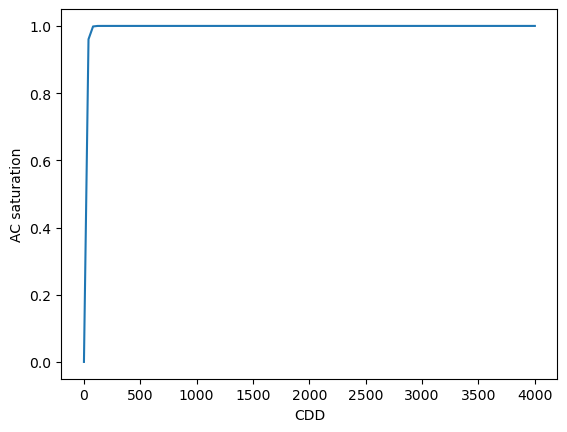

In [42]:
# Plot saturation function
cdd = np.linspace(0, 4000, 100)
plt.plot(cdd, sat(cdd, popt[0]))
plt.xlabel("CDD")
plt.ylabel("AC saturation")
plt.show()

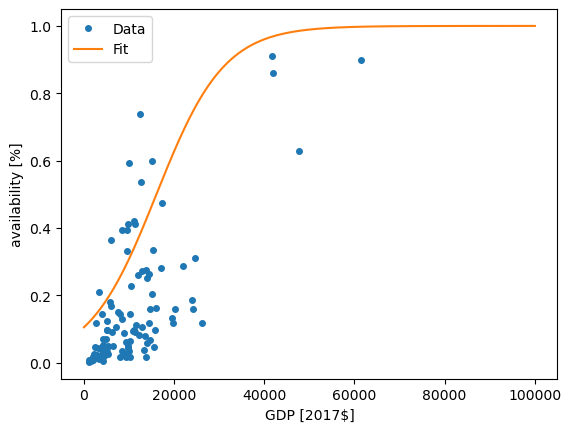

In [38]:
# Plot the availability function
fig, ax = plt.subplots()
ax.plot(ac_data["GDP"], ac_data["AC"]/sat(ac_data["CDD"], popt[0]), 'o', label="Data", markersize=4)
x = np.linspace(0, 100000, 1000)
y = avail(x, popt[1], popt[2])
ax.plot(x, y, label="Fit")
ax.set_xlabel("GDP [2017$]")
ax.set_ylabel("availability [%]")
ax.legend()